# Summary:
---

1. This notebook lists my models fitted to the data

# Reading And Embedding Fasta Files:
-----

## Parsing Fasta Files

In [1]:
import pandas as pd
from Bio import SeqIO

In [2]:
def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])

    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

In [3]:
virus1 = parseFasta("data/Sclerotinia_biocontrol_mycovirus_nucleotide.fasta")
virus1.head()

,Sequence
ID,
NC_007415.1,CTTTAGTAAATACCACCGCCTCTTAATAAGTCTCGAGGCACTCCCC...
NC_015939.1,GGGGTGATGGGAAACTTACGTTTCGCCAACGTTAAGGTACTGTGAT...
NC_022896.1,TTTTTGGGGATGGTACTCTCAGGTTTGATCTTTGTAGATCCTAACT...
NC_026510.1,TTGGCTCCTGGAGACCGTTAGGTCCCCAGAAGCGGTTCAATAGAAC...
NC_027138.1,GCAATAAAAAGCACAGCCGGAAGGCTTTCTTTTTATTGCCCAGTTT...


## Creating KMER Tables

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
def kmerXTable(s, a, b):
    tfid_vector = TfidfVectorizer(analyzer='char', ngram_range=(a,b))
    s_hat = tfid_vector.fit_transform(s.Sequence)
    kmerNames = tfid_vector.get_feature_names()
    kmers = s_hat.toarray()
    return pd.DataFrame(kmers,columns=kmerNames, index = s.index)

In [6]:
kmer7Table1 = kmerXTable(virus1, 7,7)
kmer7Table1.head()

,aaaaaaa,aaaaaac,aaaaaag,aaaaaat,aaaaaca,aaaaacc,aaaaacg,aaaaact,aaaaaga,aaaaagc,...,tttttck,tttttct,tttttga,tttttgc,tttttgg,tttttgt,tttttta,ttttttc,ttttttg,ttttttt
ID,,,,,,,,,,,,,,,,,,,,,
NC_007415.1,0.413798,0.000000,0.0,0.000000,0.000000,0.009196,0.012391,0.018391,0.000000,0.00000,...,0.0,0.000000,0.018391,0.024782,0.000000,0.009196,0.000000,0.009196,0.024782,0.021183
NC_015939.1,0.219900,0.008231,0.0,0.014071,0.005351,0.000000,0.000000,0.012217,0.006108,0.00000,...,0.0,0.008231,0.000000,0.000000,0.012217,0.012217,0.007036,0.000000,0.000000,0.000000
NC_022896.1,0.120535,0.000000,0.0,0.000000,0.000000,0.009643,0.006497,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.014464,0.009643,0.005553,0.000000,0.006497,0.000000
NC_026510.1,0.000000,0.000000,0.0,0.000000,0.014261,0.000000,0.000000,0.000000,0.016280,0.00000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NC_027138.1,0.000000,0.000000,0.0,0.000000,0.007853,0.008964,0.000000,0.008964,0.000000,0.01208,...,0.0,0.000000,0.008964,0.012080,0.000000,0.000000,0.000000,0.008964,0.000000,0.000000


# Unsupervised Predictive Models:
-----

In [7]:
virus1 = parseFasta("data/Sclerotinia_biocontrol_mycovirus_nucleotide.fasta")

virus01 = parseFasta("data/mycovirus_genbank_all_refseq_nucleotide_unique.fasta")
# put confirmed virus killers at bottom, and removed the duplicates already in the data
virus01 = virus01.append(virus1)
virus01 = virus01.drop_duplicates(keep="last")

In [8]:
kmer7Table1 = kmerXTable(virus1, 7,7)
kmer7Table01 = kmerXTable(virus01, 7,7)

## KMeans

In [9]:
from sklearn.cluster import KMeans

In [10]:
km = KMeans(random_state = 42, n_clusters = 2)

# only use columns that confirmed virus killers have no zeros in for kmer length 7
cols = kmer7Table1.loc[:, (kmer7Table1 == 0).any(axis=0) != True].columns
km.fit(kmer7Table01[cols])

# last 7 numbers in array are clusters for virus killers
y_hat = km.predict(kmer7Table01[cols])
y_hat[343:]

array([1, 1, 1, 1, 1, 1, 1])

In [11]:
y_hat

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,

## PCA with KMeans

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
km = KMeans(random_state = 42, n_clusters = 2)

# only use columns that confirmed virus killers have no zeros in for kmer length 7
cols = kmer7Table1.loc[:, (kmer7Table1 == 0).any(axis=0) != True].columns
km.fit(kmer7Table01[cols])

labels_kmeans = km.predict(kmer7Table01[cols])

In [14]:
labels_confirmed = [0 for x in range(343)] + [1 for x in range(7)]

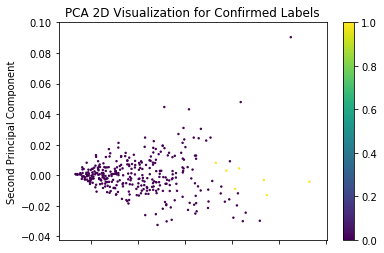

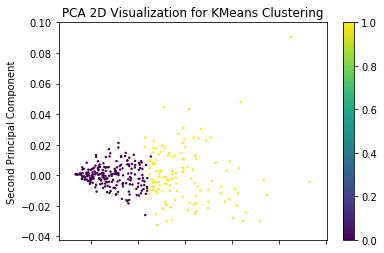

In [15]:
embedding = PCA()

# only use columns that confirmed virus killers have no zeros in for kmer length 7
cols = kmer7Table1.loc[:, (kmer7Table1 == 0).any(axis=0) != True].columns
embedding.fit(kmer7Table01[cols])

show = pd.DataFrame(embedding.transform(kmer7Table01[cols]))

# Confirmed labels
show.plot.scatter(x=0, y=1, style="o", c=labels_confirmed, cmap = "viridis", s=2)
plt.title('PCA 2D Visualization for Confirmed Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# KMeans Predicted labels
show.plot.scatter(x=0, y=1, style="o", c=labels_kmeans, cmap = "viridis", s=2)
plt.title('PCA 2D Visualization for KMeans Clustering')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

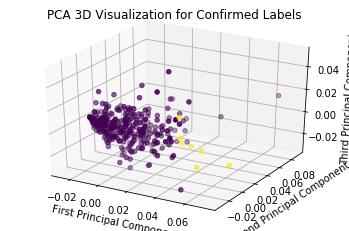

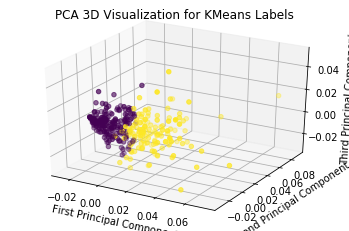

In [16]:
# Confirmed labels
ax = plt.figure().gca(projection='3d')
ax.scatter(show[0], show[1], show[2], c=labels_confirmed, cmap='viridis')
plt.title('PCA 3D Visualization for Confirmed Labels')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
plt.show()

# KMeans Predicted labels
ax = plt.figure().gca(projection='3d')
ax.scatter(show[0], show[1], show[2], c=labels_kmeans, cmap='viridis')
plt.title('PCA 3D Visualization for KMeans Labels')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
plt.show()